In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


diagnosis
B    357
M    212
Name: count, dtype: int64


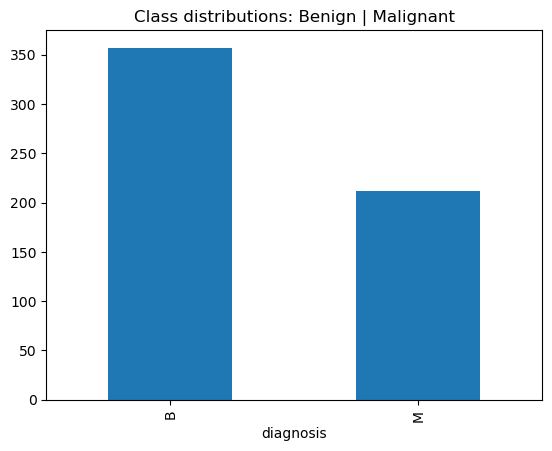

In [4]:
#Check distribution of benign + malignant samples 

value_counts = df['diagnosis'].value_counts()
print(value_counts)
plot = value_counts.plot(kind='bar', title="Class distributions: Benign | Malignant")
fig = plot.get_figure()
plt.show()

In [6]:
def plot_mean_by_category(df, feature):
    """
    Plot the mean of a feature grouped by a category.
    
    Args:
    - df: DataFrame containing the data
    - feature: Name of the feature to plot
    
    """
    grouped = df.groupby("diagnosis")[feature]
    mean_tot = df[feature].mean(axis = 0)
    sem_tot = df[feature].std(axis = 0)
    mean = grouped.mean()
    std = grouped.std()
    print(mean_tot)
    print(sem_tot)

    plt.figure(figsize=(4, 3))
    plt.bar(mean.index, mean, yerr=std, capsize=5, width=0.4)
    plt.title(f"Mean {feature} by diagnosis")
    plt.xlabel("Diagnosis")
    plt.ylabel(f"Mean {feature}")
    # plt.legend()
    plt.show()

14.127291739894552
3.524048826212078


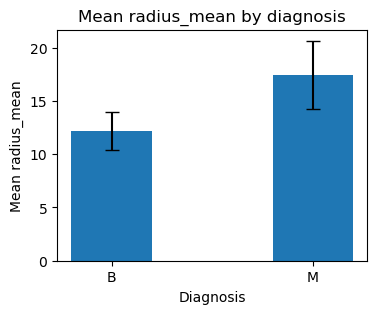

19.289648506151142
4.301035768166949


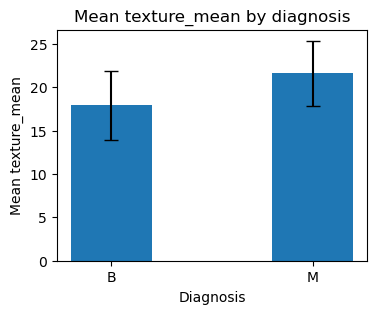

91.96903339191564
24.2989810387549


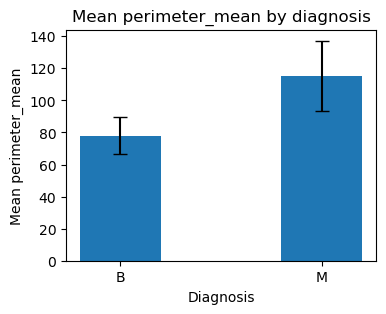

654.8891036906855
351.9141291816527


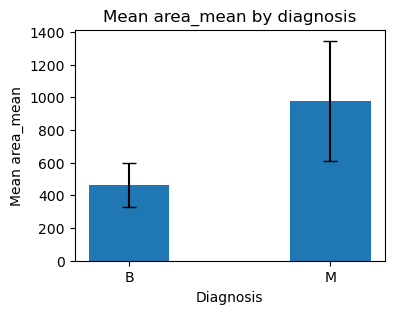

In [7]:
plot_mean_by_category(df,"radius_mean")
plot_mean_by_category(df, "texture_mean")
plot_mean_by_category(df, "perimeter_mean")
plot_mean_by_category(df, "area_mean")

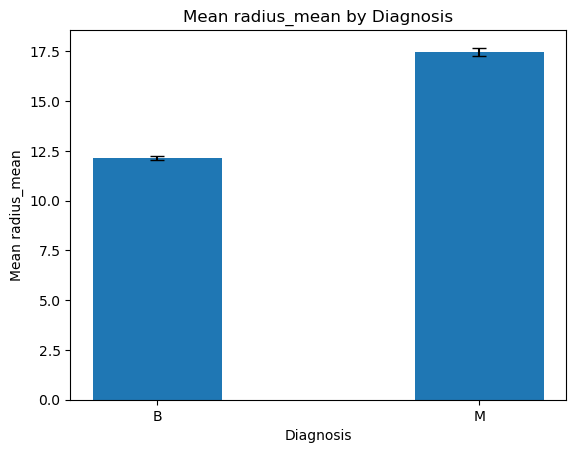

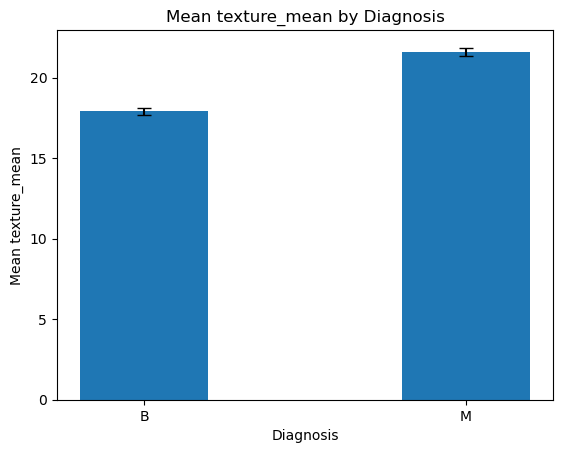

In [8]:


def plot_mean_by_category(df, feature):
    """
    Plot the mean of a feature grouped by a category.
    
    Args:
    - df: DataFrame containing the data
    - feature: Name of the feature to plot
    
    """
    grouped = df.groupby("diagnosis")[feature]
    mean = grouped.mean()
    sem = grouped.sem()

    plt.bar(mean.index, mean, yerr=sem, capsize=5, width=0.4)
    plt.title(f"Mean {feature} by Diagnosis")
    plt.xlabel("Diagnosis")
    plt.ylabel(f"Mean {feature}")
    plt.show()


plot_mean_by_category(df, "radius_mean")

# Plot mean for texture_mean
plot_mean_by_category(df, "texture_mean")


In [11]:
import matplotlib.pyplot as plt

def plot_boxplot(df, features):
    """
    Plot boxplots of multiple numerical features side by side.

    Args:
    - df: DataFrame containing the data
    - features: List of feature names to plot

    """
    num_features = len(features)
    fig, axes = plt.subplots(1, num_features, figsize=(10, 5))

    # Boxplot properties
    boxprops = dict(color='blue', linewidth=2)
    whiskerprops = dict(color='blue', linewidth=2)
    medianprops = dict(color='red', linewidth=2)
    capprops = dict(color='blue', linewidth=2)
    flierprops = dict(marker='o', markersize=8, markerfacecolor='orange', markeredgewidth=2)

    for i, feature in enumerate(features):
        axes[i].boxplot(df[feature], boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops,
                        capprops=capprops, flierprops=flierprops)
        axes[i].set_title("Box Plot")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Response")

    plt.tight_layout()
    plt.show()


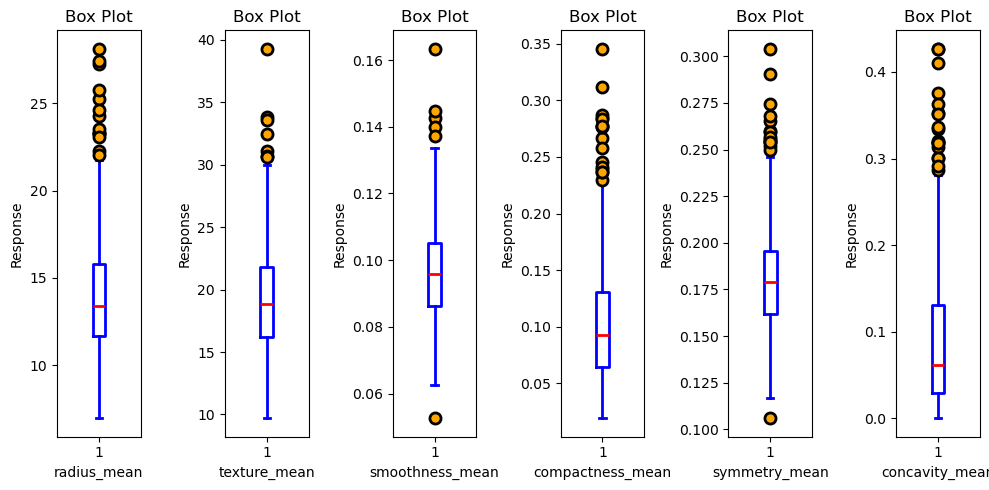

In [12]:
plot_boxplot(df,["radius_mean","texture_mean","smoothness_mean","compactness_mean","symmetry_mean","concavity_mean"])



### Logistic Regression Assumptions 
Assumptions
> The dependent variable must be binary\
> The factor ("1") should represent the success outcome\
> Only meaningful variables should be included\
> The independent variables should be independent of each other. AKA no multicolinearity\
> The independent variables are linearly related to the log odds\
> Large sample size\
> Standardizing independent variables not necessary, but it could help improve convergence

In [13]:
data = pd.read_csv("data.csv").drop(columns = ["id","Unnamed: 32"])

mapping = {"M": 1, "B": 0}
data["diagnosis"] = data["diagnosis"].map(mapping)
data.rename(columns={"concave points_mean": "concave_points_mean"}, inplace=True)
data.head()
print(data.shape)

(569, 31)


In [14]:
data.describe(include = "all")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave_points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [16]:
data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Given the above, it makes sense to eliminate Unnamed:32 

In [17]:
#find design matrix for regression model using 'diagnosis' as response variable 
y, X = dmatrices('diagnosis ~ radius_mean+texture_mean+perimeter_mean+area_mean+smoothness_mean+compactness_mean+concavity_mean+symmetry_mean', data=data, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)


           variable          VIF
0         Intercept   363.234309
1       radius_mean  1588.008548
2      texture_mean     1.178472
3    perimeter_mean  1859.871584
4         area_mean    48.127894
5   smoothness_mean     2.140459
6  compactness_mean    14.778913
7    concavity_mean     7.907826
8     symmetry_mean     1.757259


In [18]:
#remove perimeter_mean
y, X = dmatrices('diagnosis ~ radius_mean+texture_mean+area_mean+smoothness_mean+compactness_mean+concavity_mean+symmetry_mean', data=data, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

           variable         VIF
0         Intercept  358.920660
1       radius_mean   42.496917
2      texture_mean    1.178468
3         area_mean   44.318326
4   smoothness_mean    2.082434
5  compactness_mean    7.042851
6    concavity_mean    7.489782
7     symmetry_mean    1.751508


In [19]:
#remove area_mean
y, X = dmatrices('diagnosis ~ radius_mean+texture_mean+smoothness_mean+compactness_mean+concavity_mean+symmetry_mean', data=data, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

           variable         VIF
0         Intercept  173.848066
1       radius_mean    2.159299
2      texture_mean    1.178458
3   smoothness_mean    2.065050
4  compactness_mean    6.501699
5    concavity_mean    6.785569
6     symmetry_mean    1.751175


Note that sample size is acceptablly large to do logistic regression. Another way of data exploration is to make sure there are no empy values in the dataset (which will be done above)

Now that we have determined what variables to elimiate from the dataset, we may perform logistic regression. Also note that a VIF score below 7.5 is acceptable from rule of thumb

Overfitting is one of the most serious kinds of problems related to machine learning. It occurs when a model learns the training data too well. The model then learns not only the relationships among data but also the noise in the dataset. Overfitted models tend to have good performance with the data used to fit them (the training data), but they behave poorly with unseen data (or test data, which is data not used to fit the model).

Because we have a good amount of data, we can break up data into training and testing data


In [20]:
data_sorted = pd.read_csv('data.csv', usecols=['diagnosis', 'radius_mean', 'texture_mean','smoothness_mean','compactness_mean','concavity_mean','symmetry_mean'])

mapping = {"M": 1, "B": 0}
data_sorted["diagnosis"] = data_sorted["diagnosis"].map(mapping)
data_sorted

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean
0,1,17.99,10.38,0.11840,0.27760,0.30010,0.2419
1,1,20.57,17.77,0.08474,0.07864,0.08690,0.1812
2,1,19.69,21.25,0.10960,0.15990,0.19740,0.2069
3,1,11.42,20.38,0.14250,0.28390,0.24140,0.2597
4,1,20.29,14.34,0.10030,0.13280,0.19800,0.1809
...,...,...,...,...,...,...,...
564,1,21.56,22.39,0.11100,0.11590,0.24390,0.1726
565,1,20.13,28.25,0.09780,0.10340,0.14400,0.1752
566,1,16.60,28.08,0.08455,0.10230,0.09251,0.1590
567,1,20.60,29.33,0.11780,0.27700,0.35140,0.2397


In [21]:
column_data = data_sorted['diagnosis']

# Using .values attribute
array_data = column_data.values


# Using .to_numpy() method
y_data = column_data.to_numpy()
y_data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [22]:
y, X_data = dmatrices('diagnosis ~ radius_mean+texture_mean+smoothness_mean+compactness_mean+concavity_mean+symmetry_mean', data=data_sorted, return_type='dataframe')

In [23]:

x_train, x_test, y_train, y_test =\
    train_test_split(X_data, y_data, random_state=0) #test_size=0.2

Note that standardization is not neccessary, if you want you can subtract the mean and divide by stdev of each column to potentially improve accuracty however not needed

In [24]:
model = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr',
                           random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=0.05, multi_class='ovr', random_state=0,
                   solver='liblinear')

In [27]:
# model.intercept_  #model intercept Bo
model.coef_  #model slope b1

array([[-0.98314038,  0.24178848, -0.09502258, -0.05089841,  0.13179929,
         0.29611587, -0.09232821]])

In [28]:
model.predict_proba(x_train) #Once a model is defined, you can check its performance with .predict_proba(), which returns the matrix 
#of probabilities that the predicted output is equal to zero or one:

array([[0.68273267, 0.31726733],
       [0.76013538, 0.23986462],
       [0.43741785, 0.56258215],
       [0.59457065, 0.40542935],
       [0.46281082, 0.53718918],
       [0.70161572, 0.29838428],
       [0.53964216, 0.46035784],
       [0.67171016, 0.32828984],
       [0.57124636, 0.42875364],
       [0.79306865, 0.20693135],
       [0.61949904, 0.38050096],
       [0.77348329, 0.22651671],
       [0.65350317, 0.34649683],
       [0.52296562, 0.47703438],
       [0.73431107, 0.26568893],
       [0.64041331, 0.35958669],
       [0.51642159, 0.48357841],
       [0.31418371, 0.68581629],
       [0.69215588, 0.30784412],
       [0.71582834, 0.28417166],
       [0.54328732, 0.45671268],
       [0.66071884, 0.33928116],
       [0.40251995, 0.59748005],
       [0.64739155, 0.35260845],
       [0.38950042, 0.61049958],
       [0.60281457, 0.39718543],
       [0.69060626, 0.30939374],
       [0.85760872, 0.14239128],
       [0.63869338, 0.36130662],
       [0.76884583, 0.23115417],
       [0.

In the matrix above, each row corresponds to a single observation. The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥). The second column is the probability that the output is one, or 𝑝(𝑥).

You can get the actual predictions, based on the probability matrix and the values of 𝑝(𝑥), with .predict()

In [29]:
model.predict(x_train)

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [30]:
model.score(x_train, y_train)

0.7981220657276995

In [31]:
#To create the confusion matrix, you can use confusion_matrix() and provide the actual and predicted outputs as the arguments:
confusion_matrix(y_train, model.predict(x_train))
#row 1 col 1 is true negatives
#row 2 col 1 is false negative
#row 1 col 2 is false positive
# row 2 col 2 is true positive

array([[243,  24],
       [ 62,  97]])

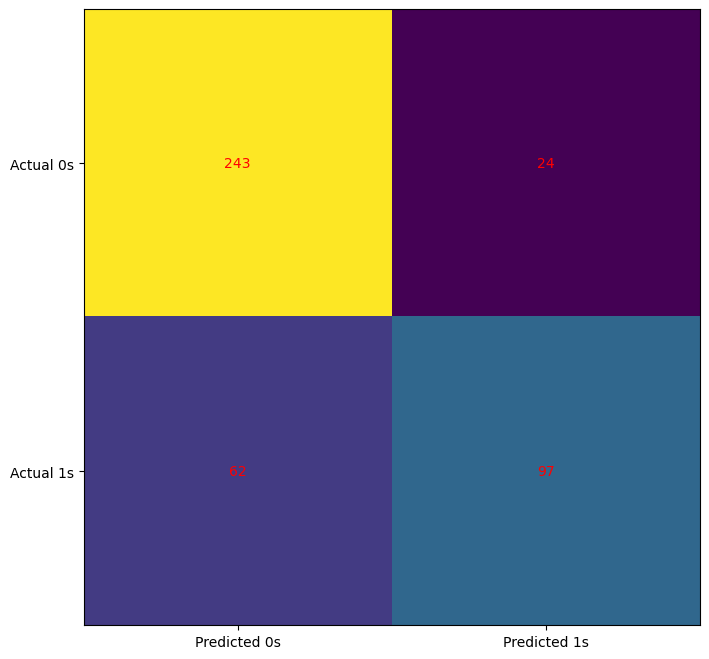

In [32]:
cm = confusion_matrix(y_train, model.predict(x_train))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

We can tune parameters but we dont want to overfit data\
Lets evaluate the model with the test data

In [33]:
y_pred = model.predict(x_test)

In [34]:
model.score(x_test, y_test) #It might be a good idea to compare the two, as a situation where the training set accuracy is much higher might indicate overfitting


0.7902097902097902

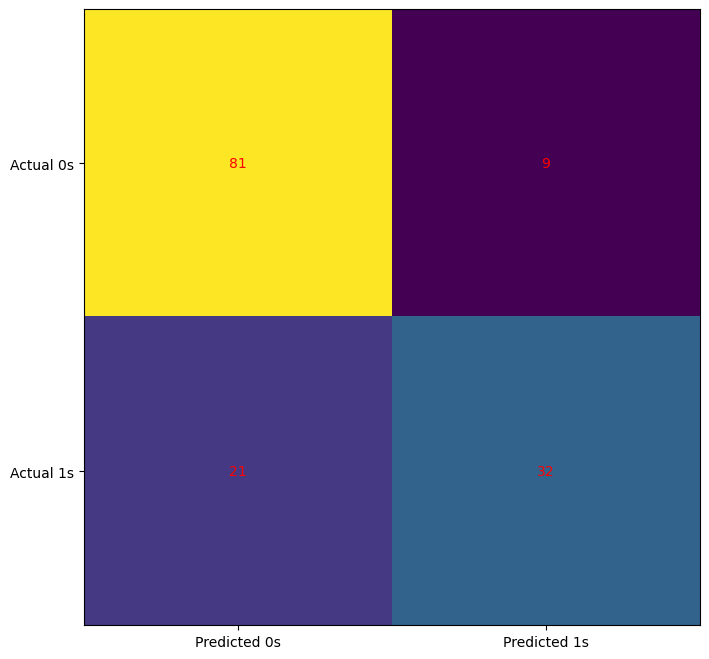

In [35]:
cm = confusion_matrix(y_test, model.predict(x_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [36]:
from sklearn.metrics import classification_report
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.79      0.90      0.84        90
   with diabetes       0.78      0.60      0.68        53

        accuracy                           0.79       143
       macro avg       0.79      0.75      0.76       143
    weighted avg       0.79      0.79      0.78       143



This means that the classifier has 79% accuracy 

In [37]:
import seaborn as sns

<Axes: xlabel='radius_mean', ylabel='diagnosis'>

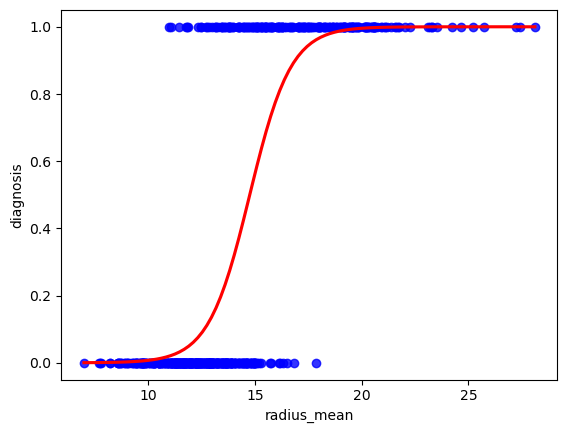

In [38]:
#define the predictor variable and the response variable
x = data_sorted["radius_mean"]
y = data_sorted["diagnosis"]

#plot logistic regression curve with black points and red line
sns.regplot(x=x, y=y, data=data_sorted, logistic=True, ci=None, scatter_kws={'color': 'blue'},line_kws={'color': 'red'})

In a similar fashion, we can check the logistic regression plot with other variables. This type of plot is only possible when fitting a logistic regression using a single independent variable. The current plot gives you an intuition how the logistic model fits an ‘S’ curve line and how the probability changes from 0 to 1 with observed values